# Do logarithmic proximity measures outperform plain ones in graph clustering?

In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../..')

In [31]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict
from sklearn.metrics import adjusted_rand_score

from pygraphs.cluster import KernelKMeans, Ward, KernelKMeansSklearn, KernelWardSklearn
from pygraphs.graphs.generators import StochasticBlockModel2, RubanovModel
from pygraphs.measure import *
from pygraphs.measure import H_kernels_plus_RSP_FE, scaler
from pygraphs.scenario import ParallelByGraphs, RejectCurve, plot_results, d3_right_order, measures_right_order
from pygraphs.colors import d3_category20

## 4. Reject curves
The optimal values of the family parameters (adjusted to the $[0, 1]$ segment) w.r.t. the ARI in clustering based on Ward’s method for three $G(N,(m)p_{in}, p_{out})$ models are presented in Table 2.

Measure $G(100,(2)0.3,0.05)$, $G(100,(2)0.3,0.1)$, $G(100,(2)0.3,0.15)$

In [9]:
all_measures = H_kernels_plus_RSP_FE + [SP_K, CT_H]
all_distances = [
    pWalk,
    Walk,
    For,
    logFor,
    Comm,
    logComm,
    Heat,
    logHeat,
    SCT,
    SCCT,
    RSP,
    FE,
    SPCT,
    SP,
    CT
]

In [10]:
rc = RejectCurve([100], [2], [0.3], [0.05, 0.1, 0.15], all_measures, all_distances, StochasticBlockModel2, Ward)

In [11]:
results_params = rc.calc(100, -1)

calc data to find best params...



find best params...
(100, 2, 0.3, 0.05)	CT H    	0.00 (0.96)
(100, 2, 0.3, 0.05)	SP K    	0.00 (0.67)
(100, 2, 0.3, 0.05)	Comm H  	0.42 (0.99)
(100, 2, 0.3, 0.05)	logComm H	0.46 (1.00)
(100, 2, 0.3, 0.05)	Heat H  	0.70 (1.00)
(100, 2, 0.3, 0.05)	Walk H  	0.82 (0.98)
(100, 2, 0.3, 0.05)	logHeat H	0.70 (1.00)
(100, 2, 0.3, 0.05)	SCT H   	0.46 (0.99)
(100, 2, 0.3, 0.05)	logFor H	0.72 (0.98)
(100, 2, 0.3, 0.05)	RSP K   	0.98 (0.98)
(100, 2, 0.3, 0.05)	For H   	0.96 (0.96)
(100, 2, 0.3, 0.05)	FE K    	0.96 (0.98)
(100, 2, 0.3, 0.05)	SCCT H  	1.00 (1.00)
(100, 2, 0.3, 0.05)	pWalk H 	0.86 (0.98)
(100, 2, 0.3, 0.05)	SP-CT H 	0.00 (0.96)
(100, 2, 0.3, 0.15)	CT H    	0.00 (0.01)
(100, 2, 0.3, 0.15)	SP K    	0.00 (0.22)
(100, 2, 0.3, 0.15)	Comm H  	0.24 (0.47)
(100, 2, 0.3, 0.15)	logComm H	0.64 (0.69)
(100, 2, 0.3, 0.15)	Heat H  	0.82 (0.20)
(100, 2, 0.3, 0.15)	Walk H  	0.76 (0.45)
(100, 2, 0.3, 0.15)	logHeat H	0.18 (0.47)
(100, 2, 0.3, 0.15)	SCT H   	0.48 (0.44)
(100, 2, 0.3, 0.15)	logFor H	0.2

In [16]:
results_rc = rc.perform(100)

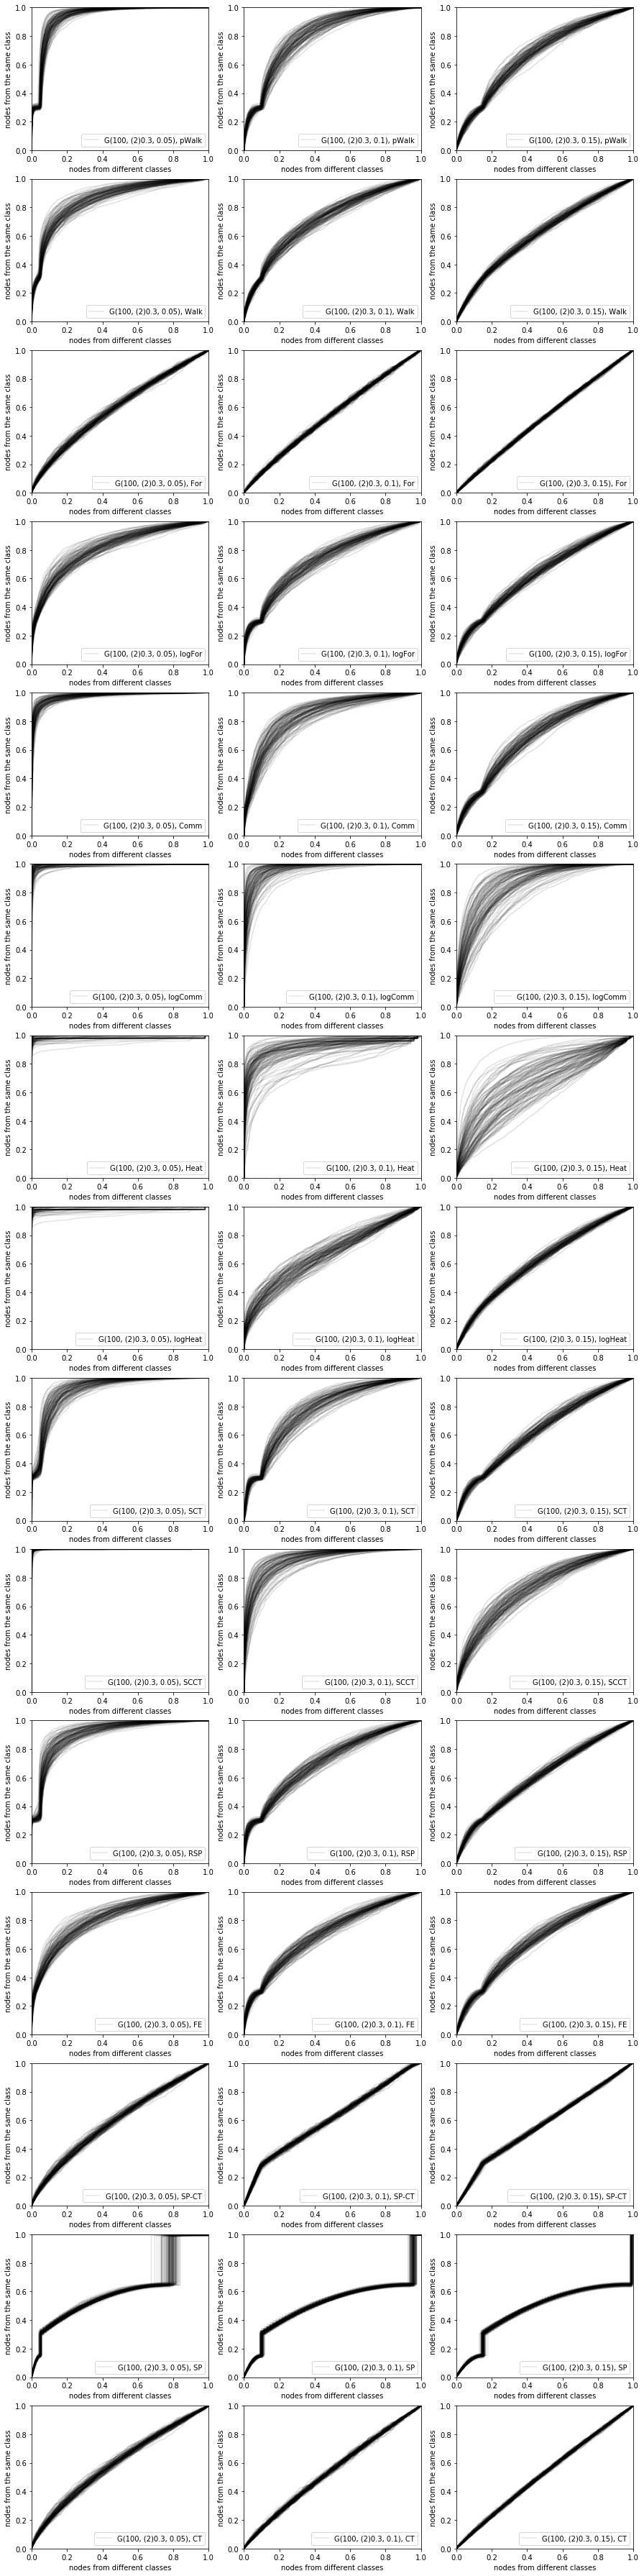

In [25]:
fig, ax = plt.subplots(15, 3, figsize=(15,65))
for column_idx, column in enumerate(results_rc.keys()):
    for measure_name_idx, measure_name in enumerate(measures_right_order):
        measure_name = measure_name[:-2]
        axi = ax[measure_name_idx][column_idx]
        for graph_idx, (tpr, fpr) in enumerate(results_rc[column][measure_name]):
            if graph_idx == 1:
                axi.plot(tpr, fpr, label="G({}, ({}){}, {}), {}".format(*column, measure_name), color='black', alpha=0.1)
            else:
                axi.plot(tpr, fpr, color='black', alpha=0.1)

        axi.set_xlabel("nodes from different classes")
        axi.set_ylabel("nodes from the same class")
        axi.set_xlim(0,1)
        axi.set_ylim(0,1)
        axi.legend(loc=4)
# gcf().suptitle("G(100,(2)0.3,0.05), G(100,(2)0.3,0.1), G(100,(2)0.3,0.15)");

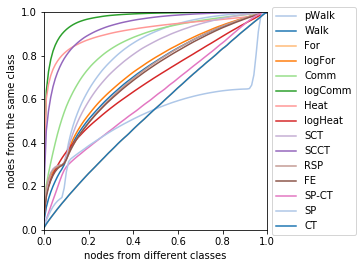

In [32]:
d3c = (x for x in itertools.chain(d3_right_order, d3_right_order))

fig, axi = plt.subplots(1, figsize=(5, 4))
for measure_name_idx, measure_name in enumerate(measures_right_order):
    measure_name = measure_name[:-2]
    tpr_all = defaultdict(list)
    for graph_idx, (tpr, fpr) in enumerate(results_rc[(100, 2, 0.3, 0.10)][measure_name]):
        tprg = defaultdict(list)
        for ti, fi in zip(fpr, tpr):
            tprg[math.floor(fi * 100)].append(ti)
        for bucket, fis in tprg.items():
            tpr_all[bucket].append(np.mean(fis))
    for bucket, fis in tpr_all.items():
        tpr_all[bucket] = np.mean(fis)
    
    axi.plot(np.array(list(tpr_all.keys()), dtype=np.float) / 100, tpr_all.values(), label=measure_name, color=d3c.__next__())

axi.set_xlabel("nodes from different classes")
axi.set_ylabel("nodes from the same class")

box = axi.get_position()
axi.set_position([box.x0, box.y0, box.width * 0.8, box.height])
axi.set_xlim(0,1)
axi.set_ylim(0,1)
axi.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# gcf().suptitle("G(100,(2)0.3,0.05), G(100,(2)0.3,0.1), G(100,(2)0.3,0.15)");

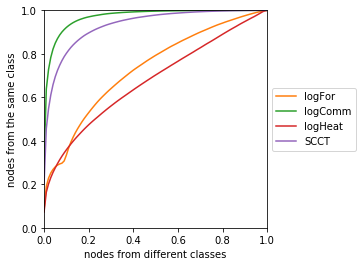

In [38]:
d3c = (x for x in itertools.chain(d3_right_order, d3_right_order))

fig, axi = plt.subplots(1, figsize=(5, 4))
for measure_name_idx, measure_name in enumerate(measures_right_order):
    measure_name = measure_name[:-2]
    tpr_all = defaultdict(list)
    for graph_idx, (tpr, fpr) in enumerate(results_rc[(100, 2, 0.3, 0.10)][measure_name]):
        tprg = defaultdict(list)
        for ti, fi in zip(fpr, tpr):
            tprg[math.floor(fi * 100)].append(ti)
        for bucket, fis in tprg.items():
            tpr_all[bucket].append(np.mean(fis))
    for bucket, fis in tpr_all.items():
        tpr_all[bucket] = np.mean(fis)
    
    color = d3c.__next__()
    
    if measure_name not in ['logComm', 'logFor', 'logHeat', 'SCCT']:
        continue
    
    axi.plot(np.array(list(tpr_all.keys()), dtype=np.float) / 100, tpr_all.values(), label=measure_name, color=color)

axi.set_xlabel("nodes from different classes")
axi.set_ylabel("nodes from the same class")

box = axi.get_position()
axi.set_position([box.x0, box.y0, box.width * 0.8, box.height])
axi.set_xlim(0,1)
axi.set_ylim(0,1)
axi.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# gcf().suptitle("G(100,(2)0.3,0.05), G(100,(2)0.3,0.1), G(100,(2)0.3,0.15)");